In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

In [2]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],  # Set to Times New Roman
    'font.size': 12,  # Set a suitable font size
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})


def calculate_P_E(data):
    attributes = [
        "pleasant",
        "eventful",
        "chaotic",
        "vibrant",
        "uneventful",
        "calm",
        "annoying",
        "monotonous",
    ]  # Define attributes to extract from dataframes
    ISOPl_weights = [
        1,
        0,
        -np.sqrt(2) / 2,
        np.sqrt(2) / 2,
        0,
        np.sqrt(2) / 2,
        -1,
        -np.sqrt(2) / 2,
    ]  # Define weights for each attribute in attributes in computation of ISO Pleasantness
    ISOEv_weights = [
        0,
        1,
        np.sqrt(2) / 2,
        np.sqrt(2) / 2,
        -1,
        -np.sqrt(2) / 2,
        0,
        -np.sqrt(2) / 2,
    ]  # Define weights for each attribute in attributes in computation of ISO Eventfulness
    P = np.mean(
        ((data[attributes] * ISOPl_weights).sum() / (4 + np.sqrt(32)))
    )  # These are normalised ISO Pleasantness values (in [-1,1])
    E = np.mean(
        ((data[attributes] * ISOEv_weights).sum() / (4 + np.sqrt(32)))
    )  # These are normalised ISO Eventfulness values (in [-1,1])
    return pd.Series({"P": P, "E": E})



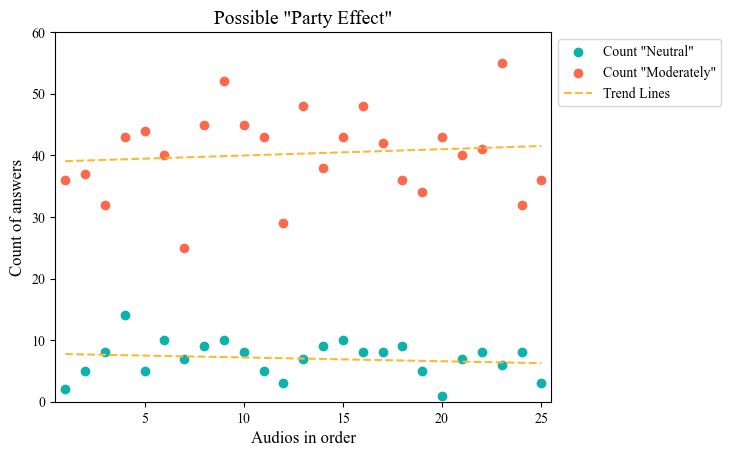

In [3]:
# Read the csv file into a DataFrame
df = pd.read_csv("../data/main_files/all_answers_listening_tests.csv", delimiter=";")

# Separate data into two sub-dataframes
general_df = pd.DataFrame(df[["order","overall"]])
reduced_general_df= pd.DataFrame(df["overall"])
emotions_df= pd.DataFrame(df[["order","pleasant","chaotic","vibrant","uneventful","calm","annoying","eventful","monotonous"]])
reduced_emotions_df= pd.DataFrame(df[["pleasant","chaotic","vibrant","uneventful","calm","annoying","eventful","monotonous"]])

# Count the number of occurrences of 3 in each row and store the result in a new column
general_df["count_of_3s"] = (reduced_general_df == 3).sum(axis=1)
emotions_df["count_of_3s"] = (reduced_emotions_df == 3).sum(axis=1)


# Group by the first column and sum the values in the second column for each group
general_df = general_df.groupby(general_df.iloc[:, 0]).sum()["count_of_3s"]
emotions_df = emotions_df.groupby(emotions_df.iloc[:, 0]).sum()["count_of_3s"]


# Calculate the trend line
x = np.arange(1,26,1)
y_general = general_df.values
slope, intercept, _, _, _ = linregress(x, y_general)
trend_line_general = slope * x + intercept
y_emotions = emotions_df.values
slope, intercept, _, _, _ = linregress(x, y_emotions)
trend_line_emotions = slope * x + intercept

# Display
plt.scatter(x,general_df.values, label='Count "Neutral"', color="#0db2ac")
plt.scatter(x,emotions_df.values, label='Count "Moderately"', color="#fc694d")
plt.plot(x, trend_line_general, color='#faba32', linestyle='--',label='Trend Lines')
plt.plot(x, trend_line_emotions, color='#faba32',linestyle='--')

# Add labels and legend
plt.xlabel('Audios in order')
plt.ylabel('Count of answers')
plt.xlim(0.5,25.5)
plt.ylim(0,60)
plt.title('Possible "Party Effect"')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# Show plot
plt.show()


In [4]:
###### PREPARE DATA ######

palette = {
    "traffic": "#FC694D",
    "construction": "#FABA32",
    "human": "#0DB2AC",
    "natural": "#84B66F"
}

# Read the csv file into a DataFrame
df = pd.read_csv("../data/main_files/all_answers_listening_tests.csv", delimiter=";")

# Apply the function to each row of the DataFrame
df[["P", "E"]] = df.apply(calculate_P_E, axis=1)

df_sources=pd.DataFrame(df[["file", "traffic", "construction", "human", "natural","pleasant","chaotic","vibrant","uneventful","calm","annoying","eventful","monotonous", "P", "E"]])
# Group by the 'file' column and calculate the mean for the other columns
grouped_df = df_sources.groupby("file").mean().reset_index()


# Find the column name with the maximum value for each row
grouped_df['Predominant sources'] = grouped_df[["traffic", "construction", "human", "natural"]].idxmax(axis=1)
df['Predominant sources'] = df[["traffic", "construction", "human", "natural"]].idxmax(axis=1)



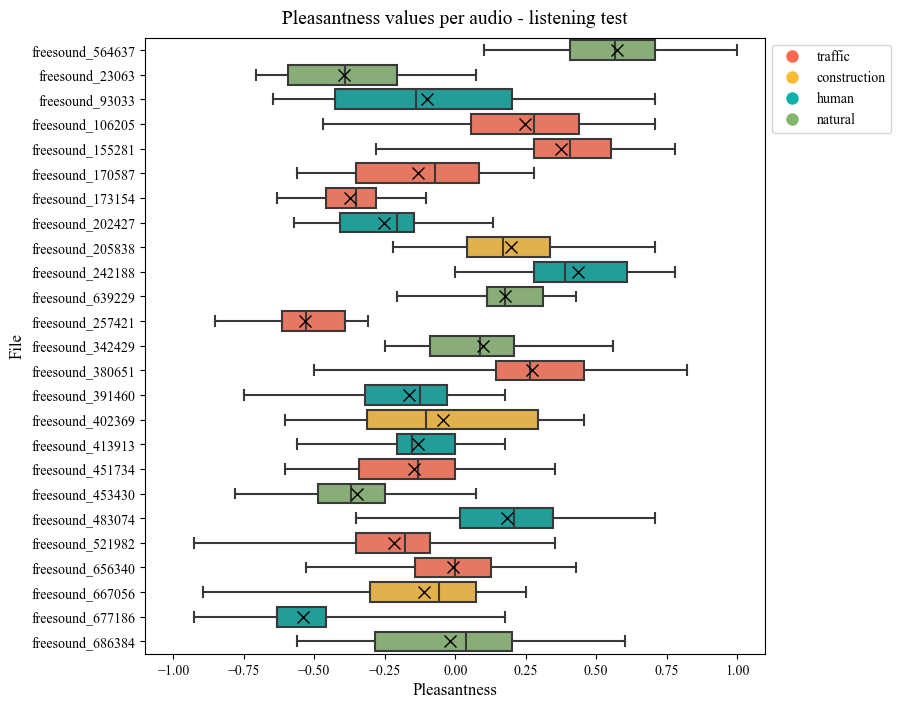

Mean variance(100-0) of all files: 0.9444722215136416
Mean variance(75-25) of all files: 0.32322853480599584


In [5]:
# Create a list of colors for each file based on its predominant source
colors = [palette[source] for source in df.groupby("file")["Predominant sources"].first()]

files= df_sources["file"].unique()
plt.figure(figsize=(8, 8))
sns.boxplot(data=df, x="P", y="file", palette=colors, whis=[0, 100],showmeans=True, meanprops={"marker":"x", "markerfacecolor":"black", "markeredgecolor":"black", "markersize":8})
legend_labels = list(palette.keys())
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[label], markersize=10, label=label) for label in legend_labels]
plt.legend(handles=legend_handles, labels=legend_labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Pleasantness values per audio - listening test", pad=10)
plt.xlabel('Pleasantness')
plt.ylabel('File')
plt.xlim(-1.1,1.1)
plt.show()

# Calculate the 0th and 100th percentiles for each file
percentiles = df.groupby("file")["P"].agg([lambda x: np.percentile(x, 0), lambda x: np.percentile(x, 100)])
# Calculate the difference between the 100th and 0th percentiles for each file
percentile_diff = percentiles.iloc[:, 1] - percentiles.iloc[:, 0]
# Calculate the mean variance of all files
mean_variance = percentile_diff.mean()
print("Mean variance(100-0) of all files:", mean_variance)

# Calculate the 25th and 75th percentiles for each file
percentiles = df.groupby("file")["P"].agg([lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])
# Calculate the difference between the 100th and 0th percentiles for each file
percentile_diff = percentiles.iloc[:, 1] - percentiles.iloc[:, 0]
# Calculate the mean variance of all files
mean_variance = percentile_diff.mean()
print("Mean variance(75-25) of all files:", mean_variance)

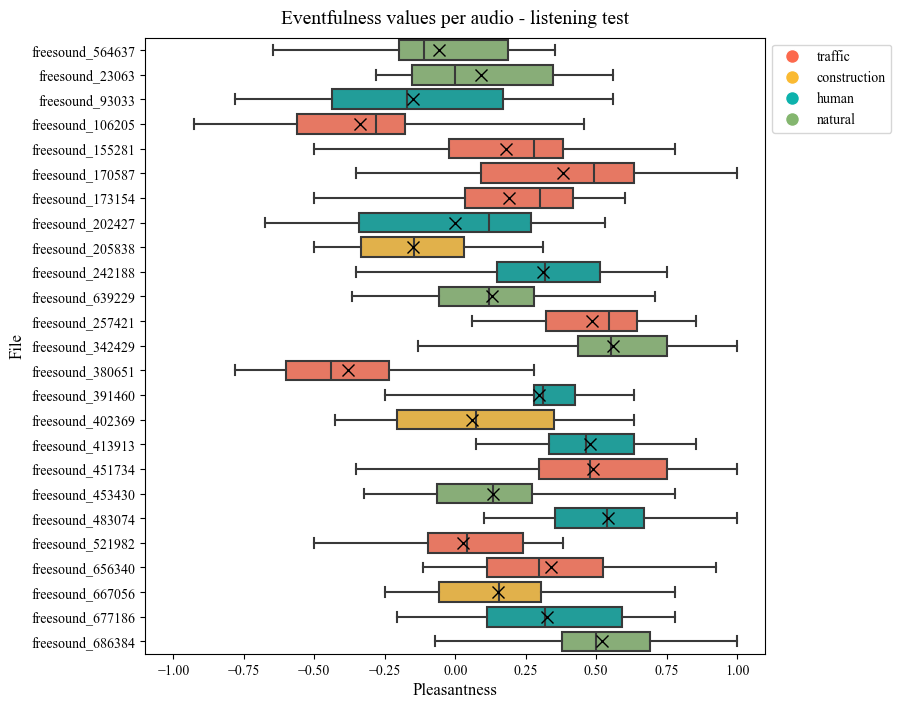

Mean variance(100-0) of all files: 1.0632590180780452
Mean variance(75-25) of all files: 0.3965343609818366


In [6]:
# Create a list of colors for each file based on its predominant source
colors = [palette[source] for source in df.groupby("file")["Predominant sources"].first()]

files= df_sources["file"].unique()
plt.figure(figsize=(8,8))
sns.boxplot(data=df, x="E", y="file", palette=colors, whis=[0, 100], showmeans=True, meanprops={"marker":"x", "markerfacecolor":"black", "markeredgecolor":"black", "markersize":8})
plt.title("Eventfulness values per audio - listening test", pad=10)
legend_labels = list(palette.keys())
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[label], markersize=10, label=label) for label in legend_labels]
plt.legend(handles=legend_handles, labels=legend_labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Pleasantness')
plt.ylabel('File')
plt.xlim(-1.1,1.1)
plt.show()

# Calculate the 0th and 100th percentiles for each file
percentiles = df.groupby("file")["E"].agg([lambda x: np.percentile(x, 0), lambda x: np.percentile(x, 100)])
# Calculate the difference between the 100th and 0th percentiles for each file
percentile_diff = percentiles.iloc[:, 1] - percentiles.iloc[:, 0]
# Calculate the mean variance of all files
mean_variance = percentile_diff.mean()
print("Mean variance(100-0) of all files:", mean_variance)

# Calculate the 25th and 75th percentiles for each file
percentiles = df.groupby("file")["E"].agg([lambda x: np.percentile(x, 25), lambda x: np.percentile(x, 75)])
# Calculate the difference between the 100th and 0th percentiles for each file
percentile_diff = percentiles.iloc[:, 1] - percentiles.iloc[:, 0]
# Calculate the mean variance of all files
mean_variance = percentile_diff.mean()
print("Mean variance(75-25) of all files:", mean_variance)

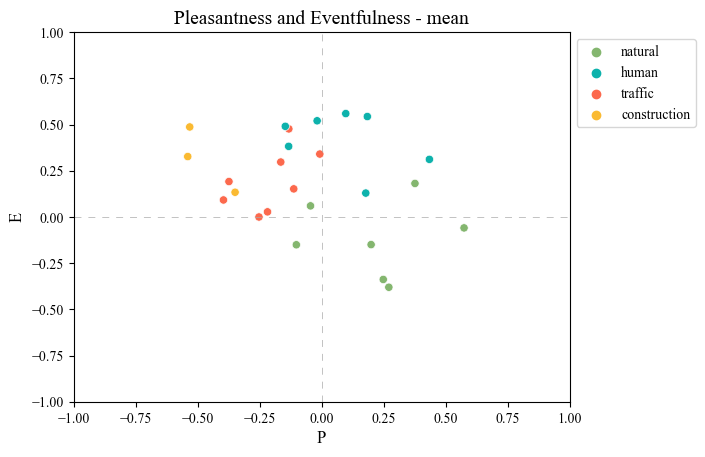

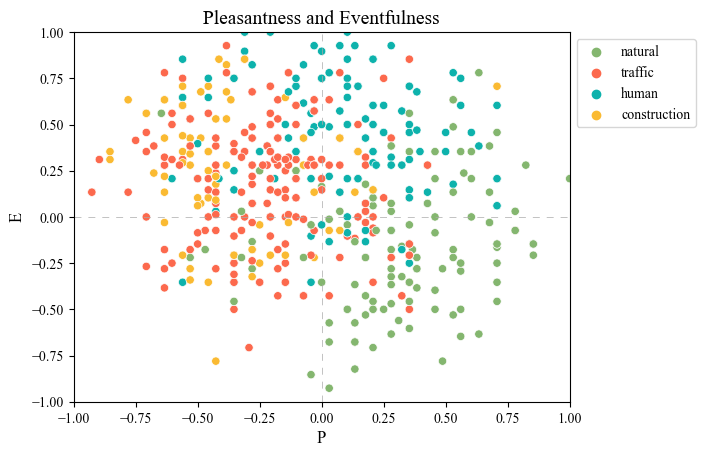

In [7]:

###### Scatter plot ######

sns.scatterplot(data=grouped_df, x="P", y="E", hue="Predominant sources", palette=palette)
# Center the axis lines at zero
plt.xlim(-1, 1)
plt.ylim(-1, 1)
# Draw axis lines like a cross in the middle
plt.axhline(0, color='#AAAAAA', linewidth=0.5,linestyle=(0, (10, 10)))
plt.axvline(0, color='#AAAAAA', linewidth=0.5,linestyle=(0, (10, 10)))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Pleasantness and Eventfulness - mean")
# Show legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# Scatter plot with different colors for each series
sns.scatterplot(data=df, x="P", y="E", hue="Predominant sources", palette=palette)
# Center the axis lines at zero
plt.xlim(-1, 1)
plt.ylim(-1, 1)
# Draw axis lines like a cross in the middle
plt.axhline(0, color='#AAAAAA', linewidth=0.5,linestyle=(0, (10, 10)))
plt.axvline(0, color='#AAAAAA', linewidth=0.5,linestyle=(0, (10, 10)))
plt.title("Pleasantness and Eventfulness")
# Show legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


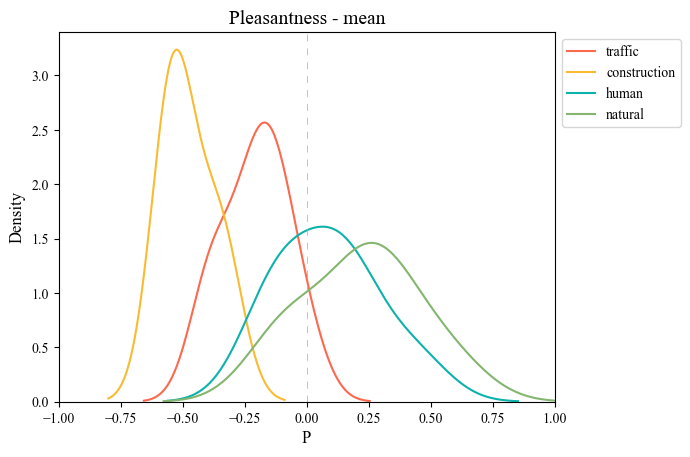

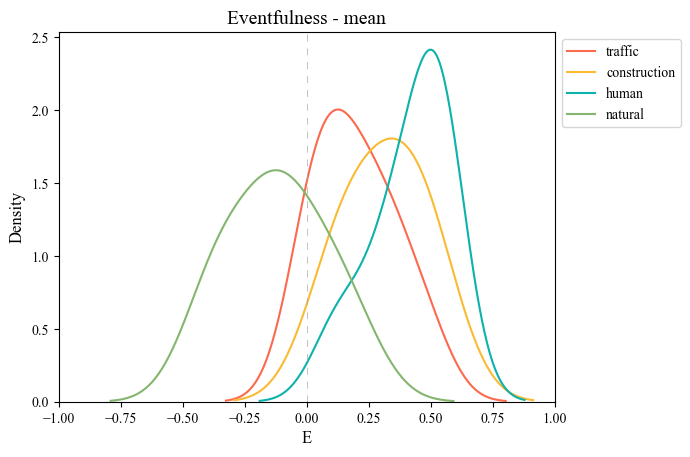

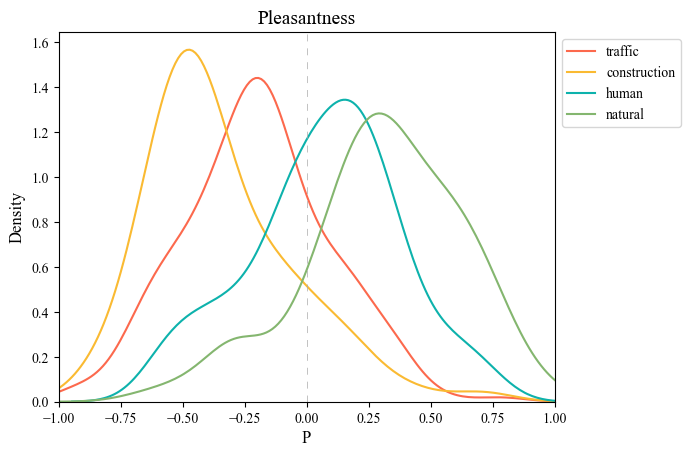

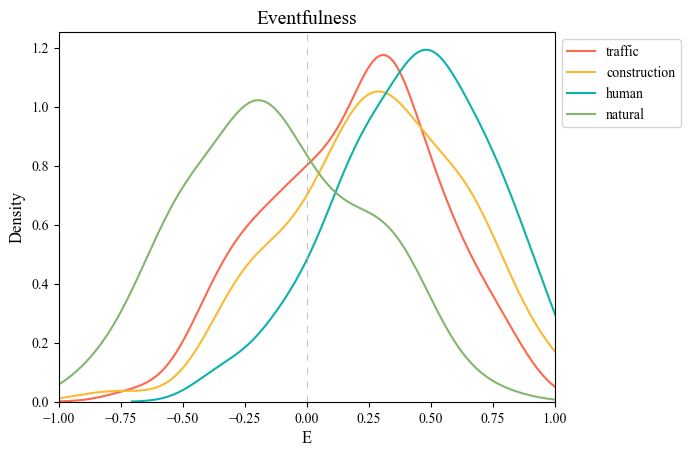

In [8]:

# KDE plots with different colors and series names
for source, color in palette.items():
    sns.kdeplot(grouped_df[grouped_df["Predominant sources"] == source]["P"], label=source, color=color)
# Draw axis lines like a cross in the middle
plt.axhline(0, color='#AAAAAA', linewidth=0.5,linestyle=(0, (10, 10)))
plt.axvline(0, color='#AAAAAA', linewidth=0.5,linestyle=(0, (10, 10)))
plt.title("Pleasantness - mean")
plt.xlim(-1,1)
# Show legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# KDE plots with different colors and series names
for source, color in palette.items():
    sns.kdeplot(grouped_df[grouped_df["Predominant sources"] == source]["E"], label=source, color=color)
# Draw axis lines like a cross in the middle
plt.axhline(0, color='#AAAAAA', linewidth=0.5,linestyle=(0, (10, 10)))
plt.axvline(0, color='#AAAAAA', linewidth=0.5, linestyle=(0, (10, 10)))
plt.title("Eventfulness - mean")
plt.xlim(-1,1)
# Show legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


# KDE plots with different colors and series names
for source, color in palette.items():
    sns.kdeplot(df[df["Predominant sources"] == source]["P"], label=source, color=color)
# Draw axis lines like a cross in the middle
plt.axhline(0, color='#AAAAAA', linewidth=0.5,linestyle=(0, (10, 10)))
plt.axvline(0, color='#AAAAAA', linewidth=0.5,linestyle=(0, (10, 10)))
plt.title("Pleasantness")
plt.xlim(-1,1)
# Show legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# KDE plots with different colors and series names
for source, color in palette.items():
    sns.kdeplot(df[df["Predominant sources"] == source]["E"], label=source, color=color)
# Draw axis lines like a cross in the middle
plt.axhline(0, color='#AAAAAA', linewidth=0.5,linestyle=(0, (10, 10)))
plt.axvline(0, color='#AAAAAA', linewidth=0.5,linestyle=(0, (10, 10)))
plt.title("Eventfulness")
plt.xlim(-1,1)
# Show legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


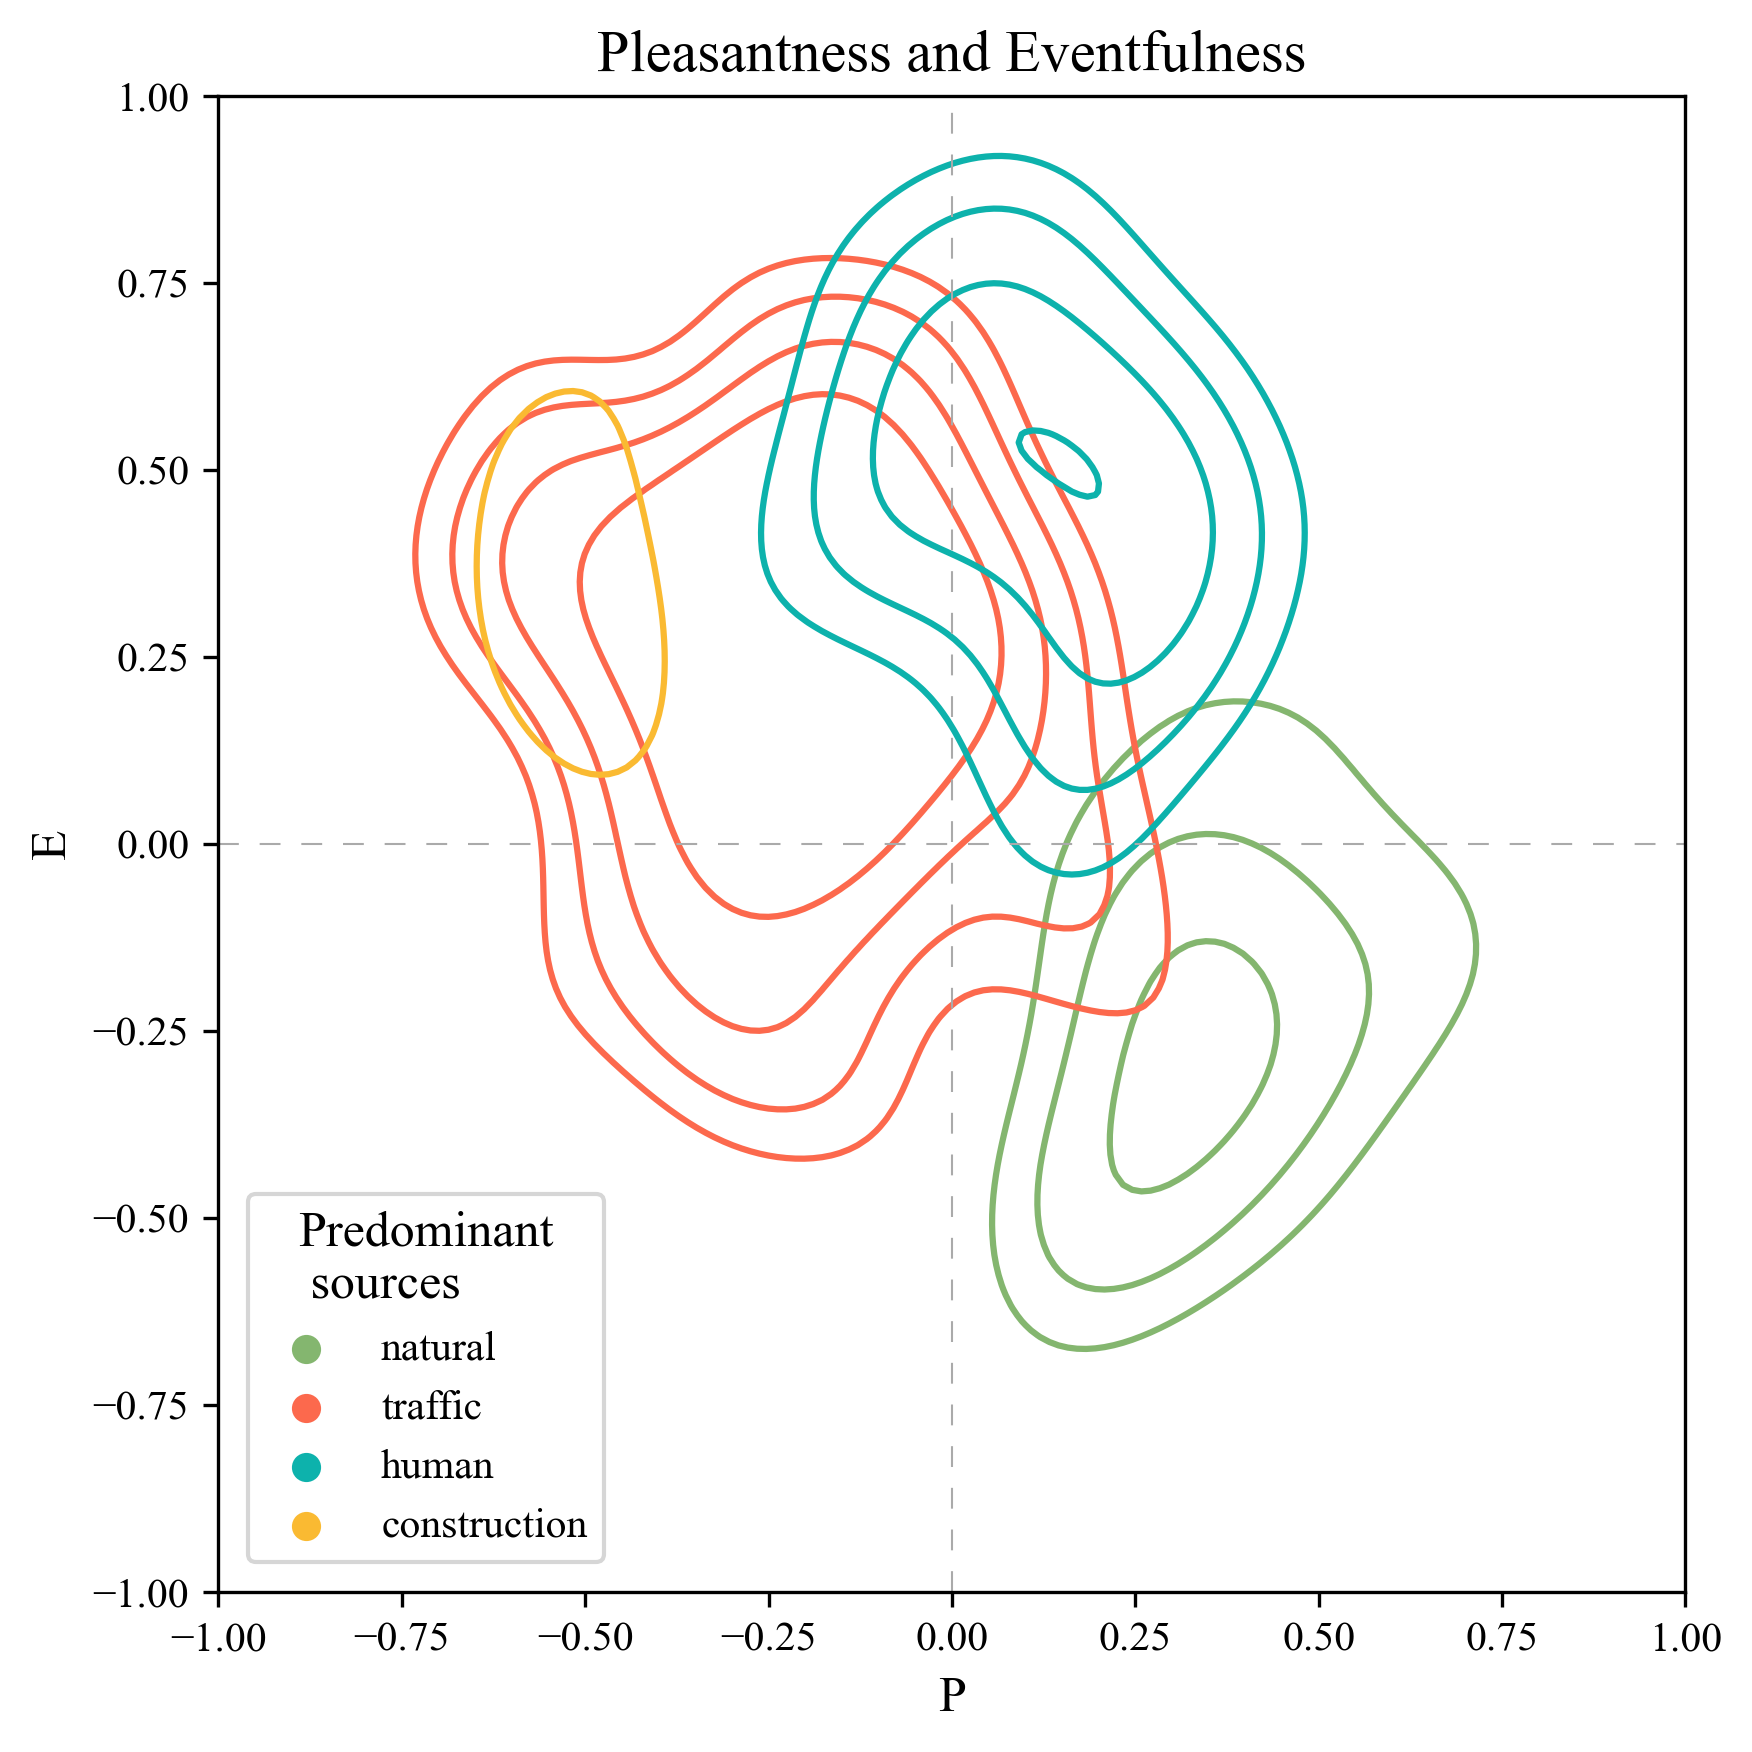

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=[6,6],dpi=300)
# Create a scatter plot to generate legend entries
sns.scatterplot(data=df, x="P", y="E", hue="Predominant sources", palette=palette, alpha=0) # I need this otherwise legend does not appear, if alpha > 0 then points are shown

sns.kdeplot(data=df, x="P", y="E", hue="Predominant sources", palette=palette, levels=5, thresh=0.5) # Plot i want to see

# Center the axis lines at zero
plt.xlim(-1, 1)
plt.ylim(-1, 1)

# Draw axis lines like a cross in the middle
plt.axhline(0, color='#AAAAAA', linewidth=0.5,linestyle=(0, (10, 10)))
plt.axvline(0, color='#AAAAAA', linewidth=0.5,linestyle=(0, (10, 10)))

plt.title("Pleasantness and Eventfulness")

# Show legend
#plt.legend(title='Predominant sources', loc='upper left', bbox_to_anchor=(1, 1))
plt.legend(title='Predominant\n sources', loc='lower left', bbox_to_anchor=(0.02, 0.02), borderaxespad=0)

plt.tight_layout()
plt.show()





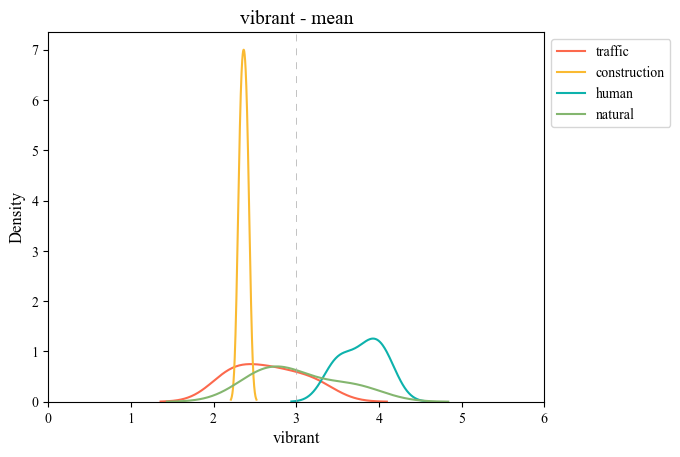

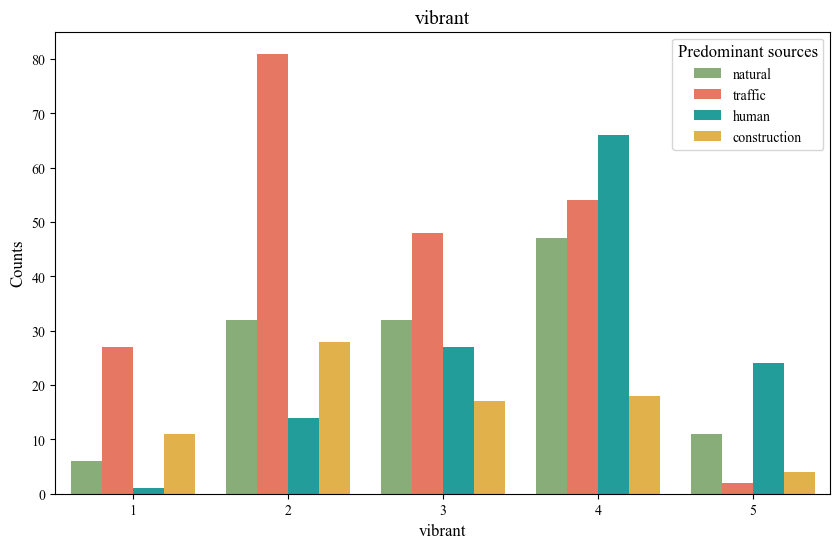

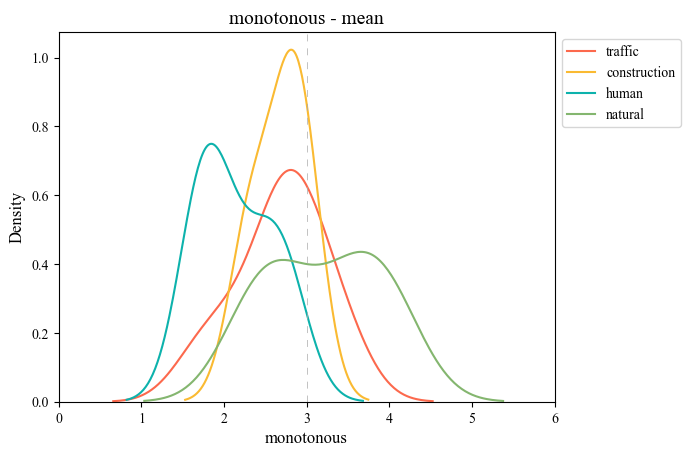

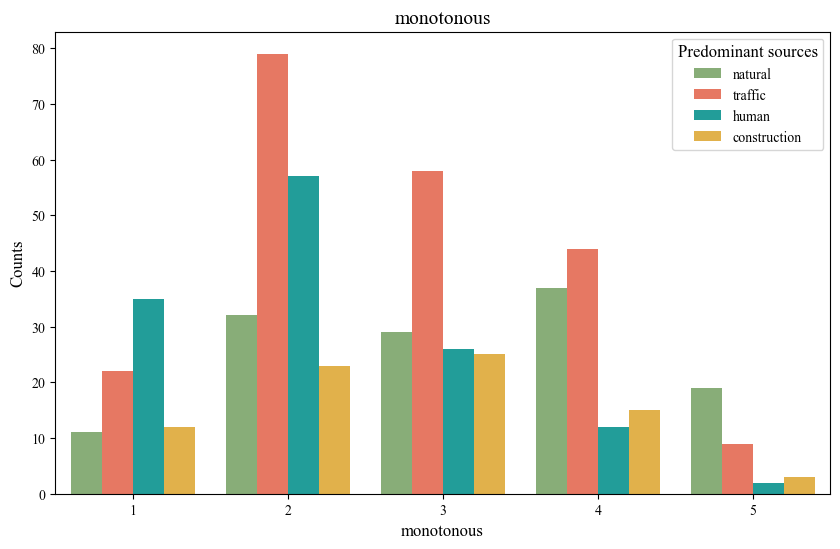

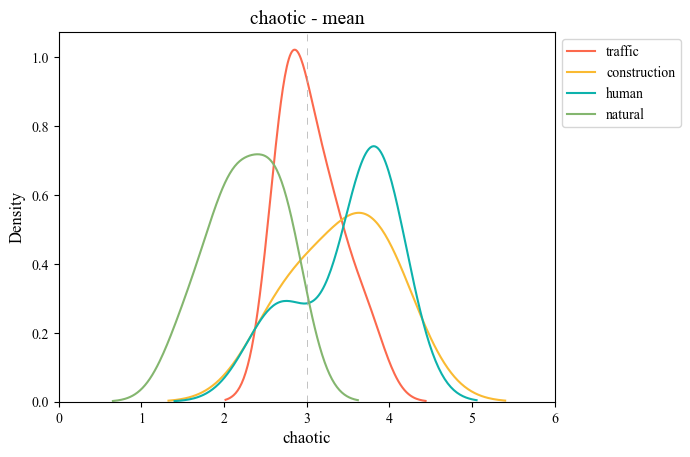

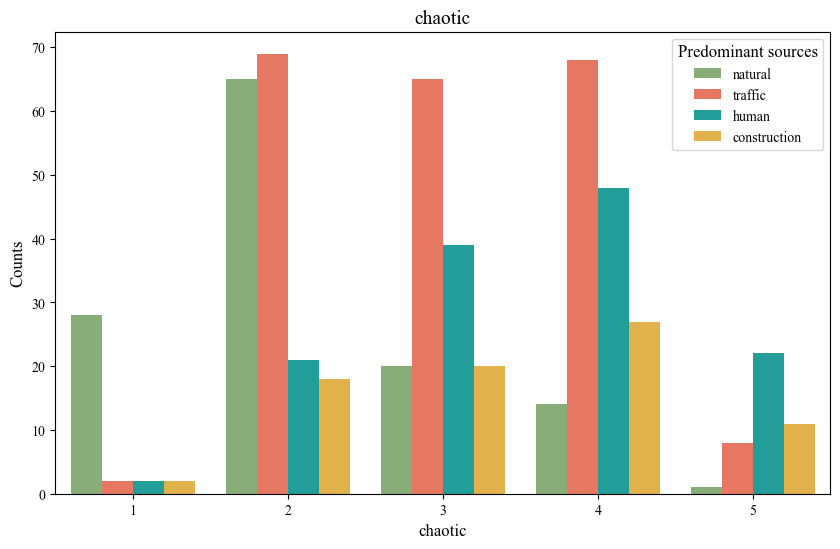

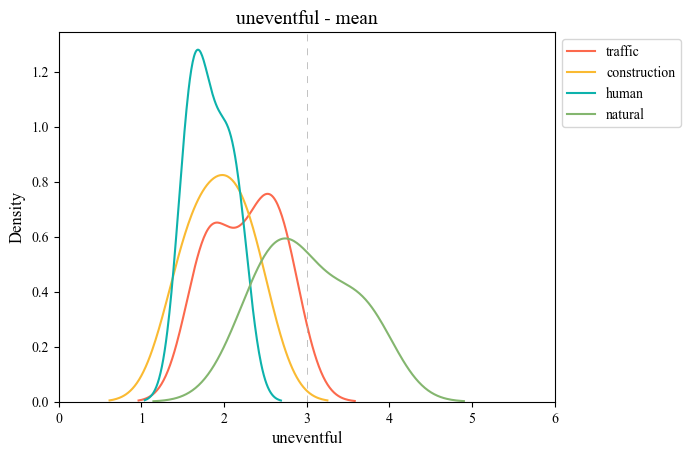

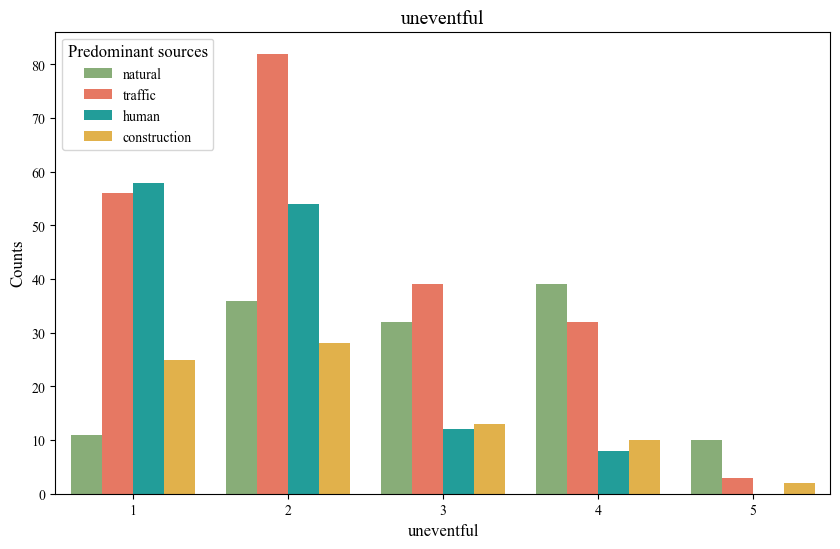

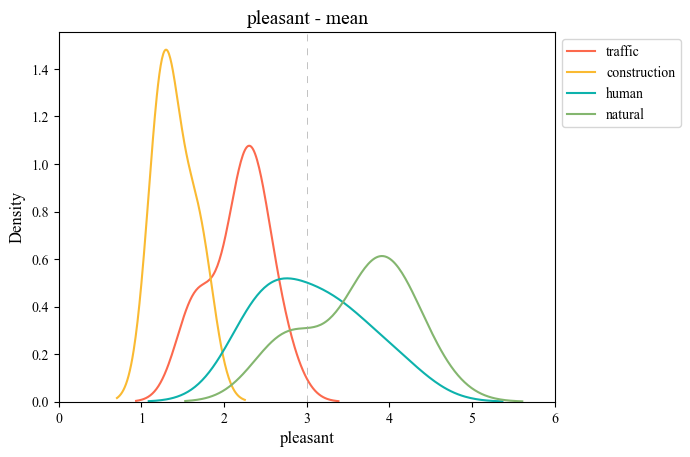

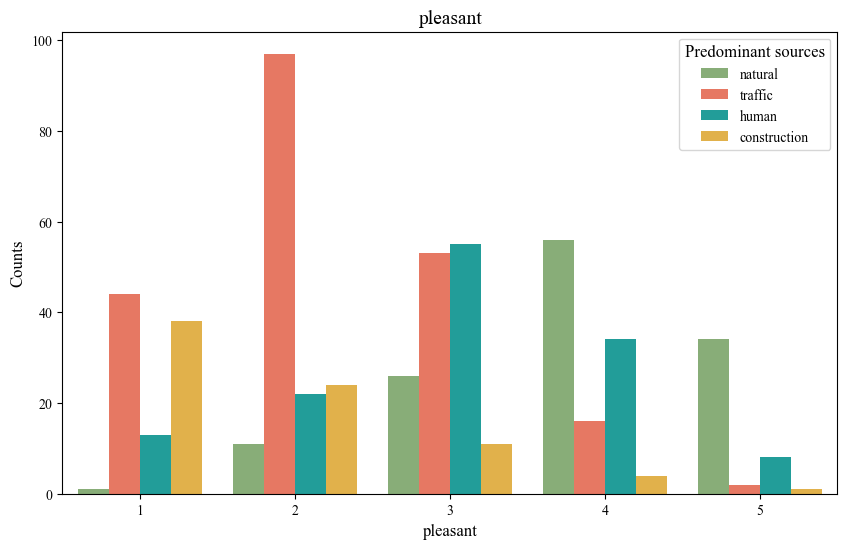

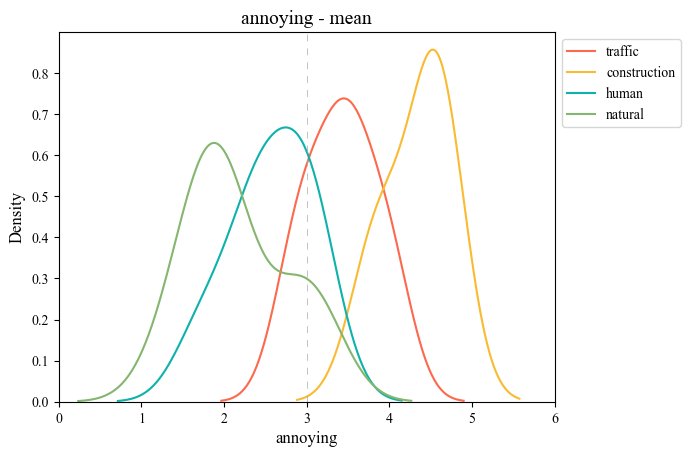

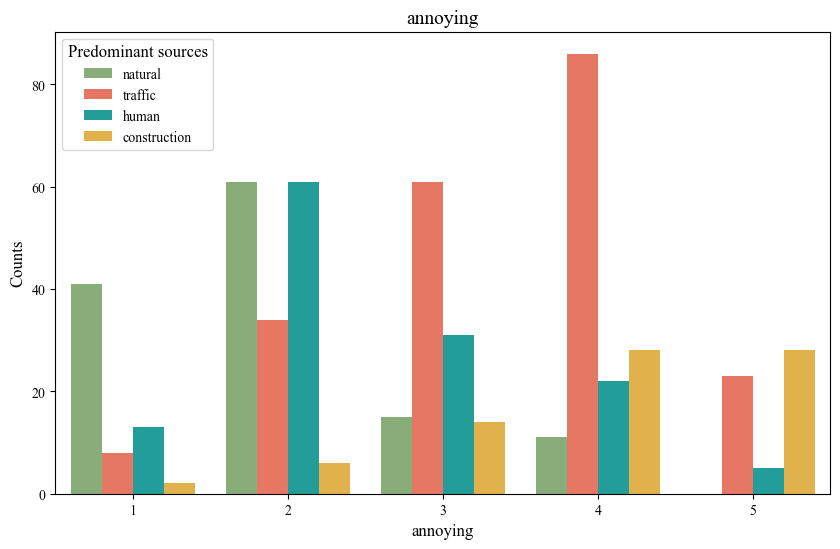

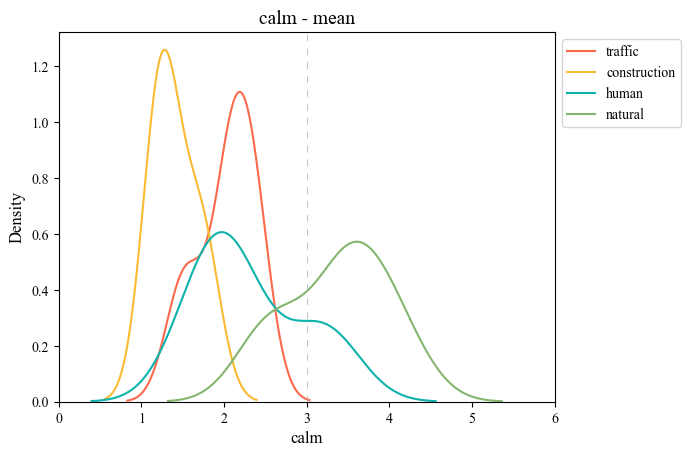

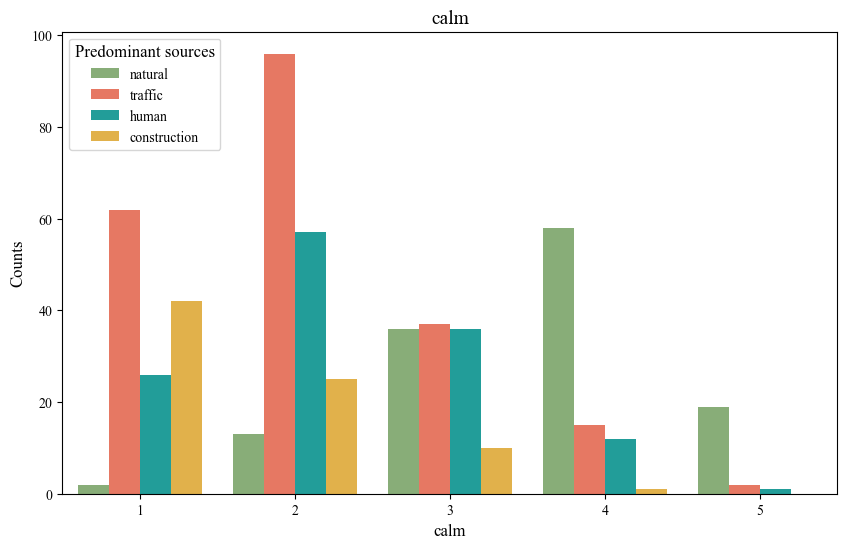

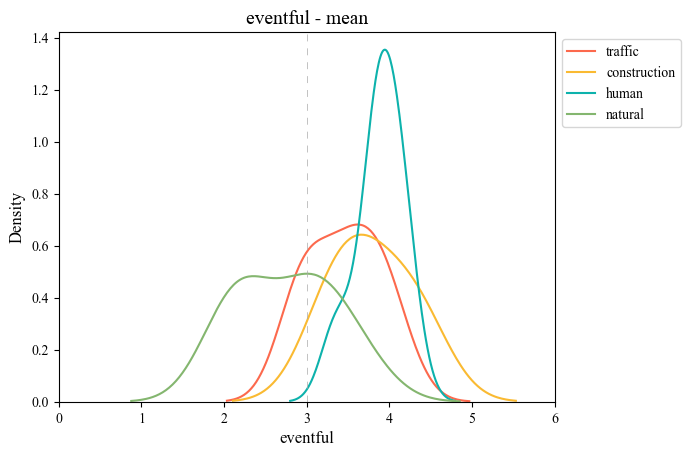

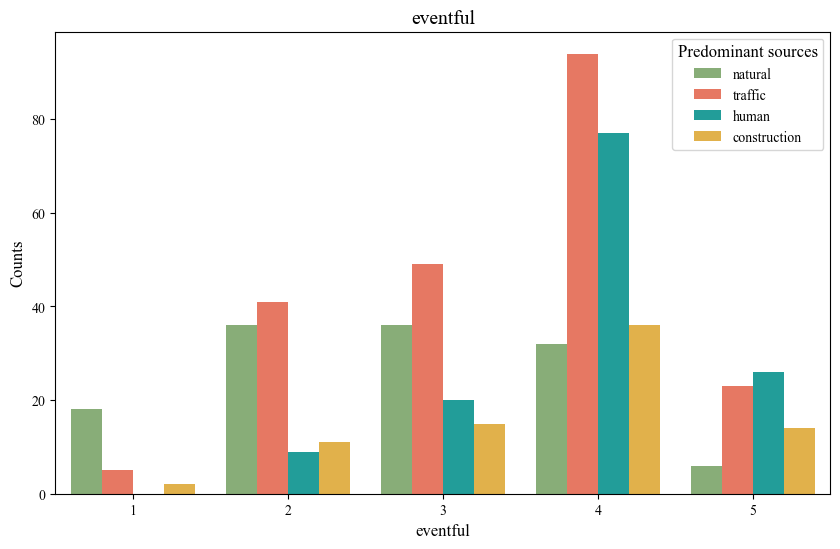

In [ ]:
values={"calm", "vibrant", "pleasant", "eventful", "chaotic", "monotonous", "annoying", "uneventful"}

for value in values:
    # KDE plots with different colors and series names
    for source, color in palette.items():
        sns.kdeplot(grouped_df[grouped_df["Predominant sources"] == source][value], label=source, color=color)
    title=value+" - mean"
    plt.title(title)
    plt.xlim([0,6])
    plt.axvline(3, color='#AAAAAA', linewidth=0.5,linestyle=(0, (10, 10)))
    # Show legend
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    # Create a count plot for each source
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=value, hue="Predominant sources", palette=palette, dodge=True)
    # Show legend
    plt.legend(title='Predominant sources')
    plt.xlabel(value)
    plt.ylabel('Counts')
    plt.title(value)
    plt.show()



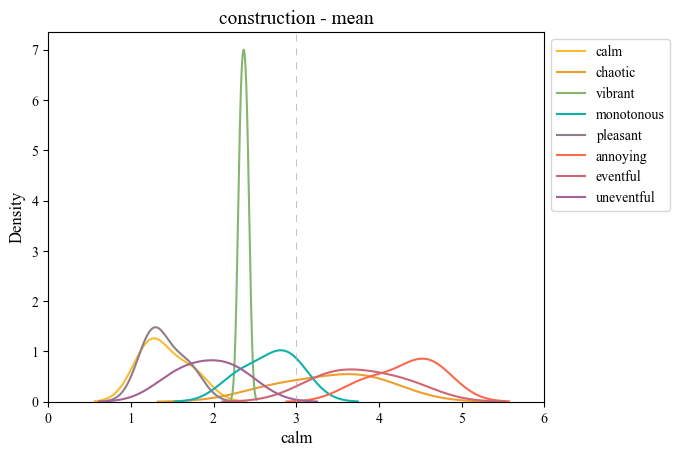

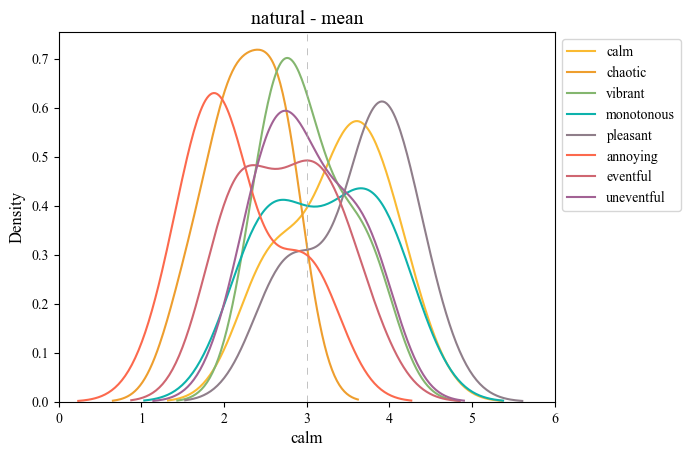

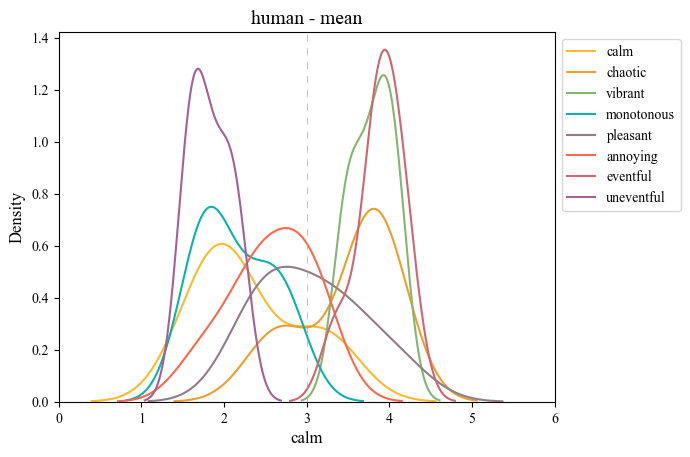

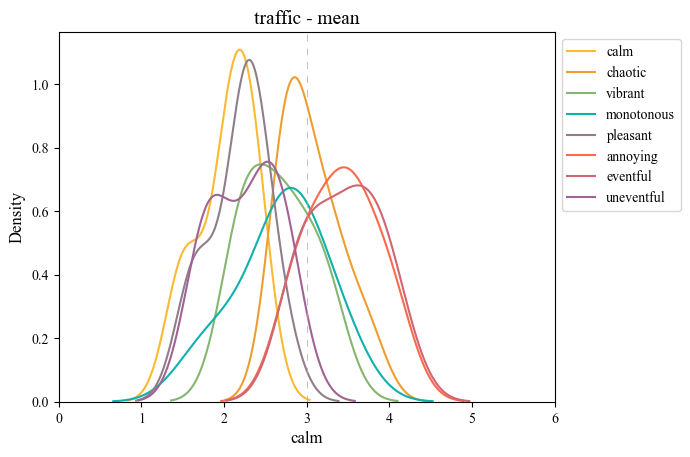

In [ ]:
values_palette={"calm":"#FABA32","chaotic":"#EE9E2E", "vibrant":"#84B66F","monotonous":"#0DB2AC", "pleasant":"#8F7E8A","annoying":"#FC694D", "eventful":"#CF6671",   "uneventful":"#A26294"}
sources={
    "traffic",
    "construction",
    "human",
    "natural"
}
for source in sources:
    # KDE plots with different colors and series names
    for value, color in values_palette.items():
        sns.kdeplot(grouped_df[grouped_df["Predominant sources"] == source][value], label=value, color=color)
    title=source+" - mean"
    plt.title(title)
    plt.axvline(3, color='#AAAAAA', linewidth=0.5,linestyle=(0, (10, 10)))
    plt.xlim([0,6])
    # Show legend
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

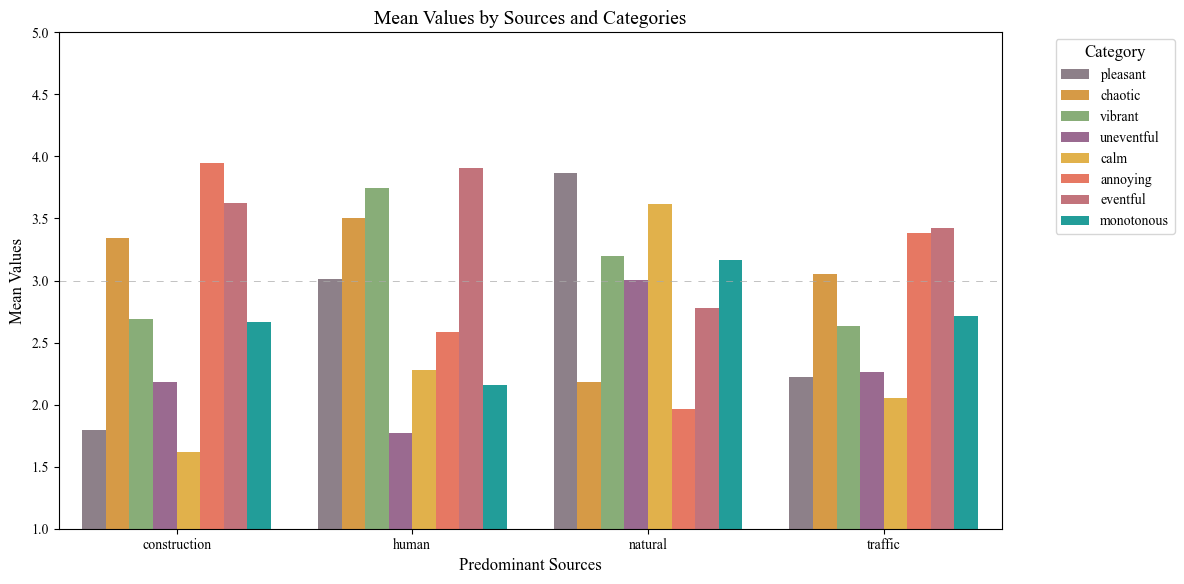

In [ ]:
categories={"calm", "vibrant", "pleasant", "eventful", "chaotic", "monotonous", "annoying", "uneventful", "Predominant sources"}
# Group by 'Predominant sources' and sum the other columns
# Group by 'Predominant sources' and compute the mean
grouped_df = df.groupby("Predominant sources").mean().reset_index()

# Convert the DataFrame to long format
df_long = grouped_df.melt(id_vars=["Predominant sources"], 
                  value_vars=["pleasant", "chaotic", "vibrant", "uneventful", "calm", "annoying", "eventful", "monotonous"],
                  var_name="Category", value_name="Value")

# Set the figure size
plt.figure(figsize=(12, 6))
plt.axhline(3, color='#AAAAAA',linestyle=(0, (10, 10)),linewidth=0.5)
# Create the bar plot
sns.barplot(data=df_long, x="Predominant sources", y="Value", hue="Category", dodge=True, palette=values_palette)
plt.ylim(1, 5)
# Add legend
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')

# Set plot title and labels
plt.title("Mean Values by Sources and Categories")
plt.xlabel("Predominant Sources")
plt.ylabel("Mean Values")

# Show plot
plt.tight_layout()
plt.show()
